# Tiktok Question 1
### Exploratory Data Analysis for Ads

p_date:  The date of ads creation (where advertiser launches an ad campaign on Ads Manager)

ad_id:  A unique identifier for a TikTok video advertisement (aka. ad group)

delivery_country: The country where the advertiser would like the ad delivered

queue_market: The country or region where the advertiser would like the ad delivered

punish_num: In the last 90 days, how many times has the advertiser of this newly created ad been punished (mostly in the form of temporary account suspension)

latest_punish_begin_date: The latest punish begin date of the advertiser. If there is no punish record for this advertiser in the past 90 days, the date is 2000/1/1

ad_revenue: How much US dollars did the ad generate for TikTok as a platform (through view, clicks, etc.)

avg_ad_revenue: Average ad revenue that TikTok recoups from the advertiser over the last 30 days

start_time: When does the advertiser want to have the delivered from?

baseline_st: ST, represents task complexity
Green Guo:
ST, represents task complexity, the higher, the more complex a task is, and may require more processing tim

#### Reply: We don't need to incorporate these fields into modeling
product_line:  What kind of ads product is being used, for example livestream ads? E-commerce ads? 

task_type_en:  What kind of ads product is being used, for example livestream ads? E-commerce ads? (more detailed)

In [120]:
import pandas as pd
xl = pd.ExcelFile("[Please refer to comments on each cell for details]ad_ranking_raw_data.xlsx")
xl.sheet_names

['ads dimension (dim table)', 'moderator dimension (dim table)']

In [121]:
# assign the first sheet to df1 and make it a Pandas DataFrame
df1 = xl.parse("ads dimension (dim table)")
df2 = xl.parse("moderator dimension (dim table)")
df1.head(3)

# make copies of original dataset incase needed in future
ori_df1 = df1.copy()
ori_df2 = df2.copy()

print(df1.shape)
# 40679 rows & 12 columns

(40680, 12)


In [122]:
# assign the first row as column values
df1.columns = df1.iloc[0]
# drop the first row that contains the column headers
df1 = df1.drop(labels = 0, axis = 0)
df1.head(3)

,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,product_line,task_type_en
1,20230807,1747578422390810,US,USCA,1,2023-07-24 00:00:00,5132.17,4795.25,2022-10-24 14:36:00,1.78,Auction Ads,auction_relation
2,20230807,1758543228094480,SA,MENA,1,2023-06-14 00:00:00,1976.25,1063.767,2023-02-22 15:50:00,1.67,RIE,Ad Group Recall (Merged)
3,20230807,1738303151826990,AU,AU,2,2023-07-24 00:00:00,1.7355,5.365,2022-07-14 05:00:00,1.84,Auction Ads,auction_relation


#### Summary of Insights
- Dataset contains  40679 rows & 12 columns
- In original dataset, all variables are of type string
- In original dataset, punish_num starts from 1, suggesting 0 values were not included and hence NULL punish_num values have been changed to 0
- Possibility of outliers
- Presence of duplicate values for ad_id, they have the same ad_revenue & avg_ad reenue but diff delivery country & baseline_St

- rows that do not have start time, do not have ad revenue. This means that these ads were never released due to moderation and hence did not generate ad revenue but tiktok can still charge the advertiser
- Hence, Null adrevenue values were given 0 value

- It seems as punish_num increases, ad revenue & avg_ad revenue decreases. Values for 4.0 & 16 might be anomalies due to small sample size of data 
- But for punish_num = 4.0, there is 14 results with significant values but with most with the same avg_ad_revenue. So values 4.0 & 16 are outliers
- so prioritse ads with punish_num = 0
- as baseline_st and ad_revenue have a normal distribution hence we should prioritse ads with baseline_st below 3.5
- US bring the most amount of ad revenue, possibility to prioritse those.

In [123]:
print(df1.dtypes)
df1.describe(include = 'all')

0
p_date                      object
ad_id                       object
delivery_country            object
queue_market                object
punish_num                  object
latest_punish_begin_date    object
ad_revenue                  object
avg_ad_revenue              object
start_time                  object
baseline_st                 object
product_line                object
task_type_en                object
dtype: object


,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,product_line,task_type_en
count,40679,40679,40679,19524,2393,40679,29908.0,40679.0,34004,40679.00,40679,40679
unique,1,35829,59,51,7,87,18970.0,18922.0,9608,68.00,4,9
top,20230807,1773564011076700,US,Other,1,2000-01-01 00:00:00,0.0,0.0,2023-08-06 11:37:00,0.54,Non-Auction Ads,Promote
freq,40679,46,3987,1855,2194,38286,1491.0,644.0,278,18291.00,18669,18291


This tells us that the type of all columns is in String and not in Integer/float 

Hence we might have to convert the types of certain columns such as ['punish_num', 'ad_revenue', 'avg_ad_revenue', 'baseline_st']. 

##### To explore if the date columns needed to be changed to DateTime & if difference needs to be taken from punishment_Start_date - release_of_ad_date

##### Why is there duplicate ad IDs???

One possible reason for this is that the duplicate ad ID is the same ad but released to a different country. This was verified via the exploratory data analysis

In [124]:
# change the type to float & check it
df1 = df1.astype({'punish_num':'float','ad_revenue':'float','avg_ad_revenue':'float','baseline_st':'float'})
print(df1.dtypes)

0
p_date                       object
ad_id                        object
delivery_country             object
queue_market                 object
punish_num                  float64
latest_punish_begin_date     object
ad_revenue                  float64
avg_ad_revenue              float64
start_time                   object
baseline_st                 float64
product_line                 object
task_type_en                 object
dtype: object


In [125]:
import numpy as np
# for the numeric cols
df1.describe()

,punish_num,ad_revenue,avg_ad_revenue,baseline_st
count,2393.00000,29908.000000,40679.000000,40679.000000
mean,1.14041,74.508358,23.887703,1.206670
std,0.84125,490.403509,187.580436,0.659845
min,1.00000,0.000000,0.000000,0.540000
25%,1.00000,1.390450,0.835250,0.540000
50%,1.00000,5.979250,2.597900,1.400000
75%,1.00000,20.260000,8.269100,1.780000
max,16.00000,27100.620000,17144.498600,7.590000


Average punishment tend to be 1.14 times, ad_revenue is USD 74, avg_ad_revenue for last 30 days is USD 23.88
Baseline_St ???????

##### -> Possibility of outliers for all three, further analysis is needed

### Handling Missing Values

In [126]:
# Checking for missing values
df1.isnull().sum()

0
p_date                          0
ad_id                           0
delivery_country                0
queue_market                21155
punish_num                  38286
latest_punish_begin_date        0
ad_revenue                  10771
avg_ad_revenue                  0
start_time                   6675
baseline_st                     0
product_line                    0
task_type_en                    0
dtype: int64

Index(['queue_market', 'punish_num', 'ad_revenue', 'start_time'], dtype='object', name=0)

This tells us that these 4 columns have NA values. As the null values are quite high, we cannot simply drop them. We shall explore to see any reasoning behind the null values or if they even affect our data

In [127]:
# set up filtering condition to display rows that have both 'start_time' & 'ad_revenue' col as NULL
filt = (df1['start_time'].isna() == True) & (df1['ad_revenue'].isna() == True)
df1.loc[filt]

,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,product_line,task_type_en
3512,20230807,1773582987849730,BR,NaN,1.0,2023-08-07 00:00:00,NaN,12.6232,NaN,0.54,Non-Auction Ads,Promote
3527,20230807,1773565701589040,BR,NaN,1.0,2023-08-07 00:00:00,NaN,8.9154,NaN,0.54,Non-Auction Ads,Promote
3531,20230807,1773564005497860,BR,NaN,1.0,2023-08-07 00:00:00,NaN,3.7262,NaN,0.54,Non-Auction Ads,Promote
3532,20230807,1773371474970620,SA,NaN,1.0,2023-08-07 00:00:00,NaN,3.4594,NaN,0.54,Non-Auction Ads,Promote
3533,20230807,1773518080476160,SA,NaN,1.0,2023-08-07 00:00:00,NaN,3.4574,NaN,0.54,Non-Auction Ads,Promote
...,...,...,...,...,...,...,...,...,...,...,...,...
40675,20230807,1773472206047230,VN,NaN,NaN,2000-01-01 00:00:00,NaN,0.0000,NaN,0.54,Non-Auction Ads,Promote
40676,20230807,1773607712030720,BR,NaN,NaN,2000-01-01 00:00:00,NaN,0.0000,NaN,0.54,Non-Auction Ads,Promote
40677,20230807,1773589699308540,BE,NaN,NaN,2000-01-01 00:00:00,NaN,0.0000,NaN,0.54,Non-Auction Ads,Promote
40678,20230807,1773530511220730,TR,NaN,NaN,2000-01-01 00:00:00,NaN,0.0000,NaN,0.54,Non-Auction Ads,Promote


Number of rows without start time == number of rows without (start time & ad_revenue)

###### Hence this tells us that the rows that do not have start dates also do not have ad_revenue, maybe is becuase these ads failed Tiktok's review process and hence was not deployed 
##### BUT had to pay momey for said ad / average for other ads by the same advertiser is shown on the column beside

Hence we shall input the ad_revenue values to 0

The same will be done punish_num as the number of null values is 38k & min value for punish_num is 1, suggesting that those that where not punished might not have a value recorded

Hence we shall make NA values in punish_num to 0 as well.

Start time will be left as null as the ADS were never released

In [128]:
df1['ad_revenue'] = df1['ad_revenue'].fillna(0)
df1['punish_num'] = df1['punish_num'].fillna(0)
df1['ad_revenue'].isnull().sum()
# as all NULL ad_revenue values are filled with 0 there are no more NULL values for that row

0

### Checking for Outliers

### Exploring Individual Elements

In [129]:
# get the top 10 highest countries where ads must be delivered as total percentages
df1['delivery_country'].value_counts(normalize = True)[:10]

US    0.098011
SA    0.090292
ID    0.088104
TH    0.086777
VN    0.086089
BR    0.068045
MY    0.041004
TR    0.036923
PH    0.029401
GB    0.028049
Name: delivery_country, dtype: float64

In [130]:
# seeing the distribution of number of ads that were "punished"
# unable to plot a grpah due to the extreme values present

df1['punish_num'].value_counts()
# df1['punish_num'].value_counts(normalize = True)

0.0     38286
1.0      2194
2.0       163
4.0        14
3.0        13
16.0        5
12.0        2
5.0         2
Name: punish_num, dtype: int64

In [131]:
# df1 -> groupby values in punish_num col -> take the ad_revene & avg_Ad_revenue  col -> find the mean for it
df1.groupby('punish_num')['ad_revenue','avg_ad_revenue'].agg(['mean'])

/var/folders/xv/b11rtkss1v3_w8__j41y1m_00000gn/T/ipykernel_16036/1190657423.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1.groupby('punish_num')['ad_revenue','avg_ad_revenue'].agg(['mean'])


,ad_revenue,avg_ad_revenue
,mean,mean
punish_num,,
0.0,55.924302,24.225939
1.0,36.878172,19.043529
2.0,16.473484,10.477039
3.0,12.464985,11.660792
4.0,98.529000,30.761064
5.0,7.928000,9.314800
12.0,0.587650,2.427000
16.0,424.758000,23.712900


In [132]:
df1[df1['punish_num'] == 4.0]

,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,product_line,task_type_en
14,20230807,1763582835715070,MY,MY,4.0,2023-05-24 00:00:00,59.080,24.8528,2023-04-19 06:53:00,2.30,RIE,Ad Group Recall (Merged)
15,20230807,1763766858169370,MY,MY,4.0,2023-05-24 00:00:00,71.450,24.8528,2023-04-21 07:38:00,2.30,RIE,Ad Group Recall (Merged)
19,20230807,1767027023555630,TH,TH,4.0,2023-05-24 00:00:00,31.780,24.8528,2023-05-27 07:20:00,1.87,RIE,Ad Group Recall (Merged)
20,20230807,1767187528079370,ID,ID,4.0,2023-05-24 00:00:00,35.270,24.8528,2023-05-29 02:01:00,2.05,RIE,Ad Group Recall (Merged)
21,20230807,1767187070801970,ID,ID,4.0,2023-05-24 00:00:00,36.480,24.8528,2023-05-29 02:01:00,2.05,RIE,Ad Group Recall (Merged)
22,20230807,1767187070787580,ID,ID,4.0,2023-05-24 00:00:00,31.670,24.8528,2023-05-29 02:01:00,2.05,RIE,Ad Group Recall (Merged)
23,20230807,1767187070795790,ID,ID,4.0,2023-05-24 00:00:00,61.170,24.8528,2023-05-29 02:01:00,2.05,RIE,Ad Group Recall (Merged)
24,20230807,1767392366439450,TH,TH,4.0,2023-05-24 00:00:00,217.800,24.8528,2023-05-31 08:04:00,1.87,RIE,Ad Group Recall (Merged)
27,20230807,1767567705104400,VN,VN,4.0,2023-05-24 00:00:00,87.850,24.8528,2023-06-02 06:31:00,2.13,RIE,Ad Group Recall (Merged)
29,20230807,1768110086084620,MY,MY,4.0,2023-05-24 00:00:00,54.560,24.8528,2023-06-08 06:12:00,2.30,RIE,Ad Group Recall (Merged)


## Additional insights
##### - It seems as punish_num increases, ad revenue & avg_ad revenue decreases. Values for 4.0 & 16 might be anomalies due to small sample size of data 
- But for punish_num = 4.0, there is 14 results with significant values but with most with the same avg_ad_revenue. So values 4.0 & 16 are outliers

In [133]:
# exploring duplicates in ad_id 
# Notice that ad_revenue & avg_revenue are the same but start time & baseline_st is different, 
## maybe due to diff country!!
df1.loc[df1.duplicated(subset = ['ad_id'])].head(6)

,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,product_line,task_type_en
44,20230807,1762072797178930,US,US&CA,1.0,2023-06-26 00:00:00,1.9800,0.9749,2023-04-02 14:52:00,1.81,RIE,Ad Group Recall (Merged)
45,20230807,1762072797178930,GB,GB,1.0,2023-06-26 00:00:00,1.9800,0.9749,2023-04-02 14:52:00,1.72,RIE,Ad Group Recall (Merged)
49,20230807,1769433242777640,BY,BY,2.0,2023-06-05 00:00:00,17.3111,9.5609,2023-06-22 20:35:00,2.14,Auction Ads,auction_relation
50,20230807,1769433242777640,ID,ID,2.0,2023-06-05 00:00:00,17.3111,9.5609,2023-06-22 20:35:00,1.80,Auction Ads,auction_relation
51,20230807,1769433242777640,CL,CL,2.0,2023-06-05 00:00:00,17.3111,9.5609,2023-06-22 20:35:00,1.85,Auction Ads,auction_all
52,20230807,1769433242777640,NL,NL,2.0,2023-06-05 00:00:00,17.3111,9.5609,2023-06-22 20:35:00,1.19,Auction Ads,auction_relation


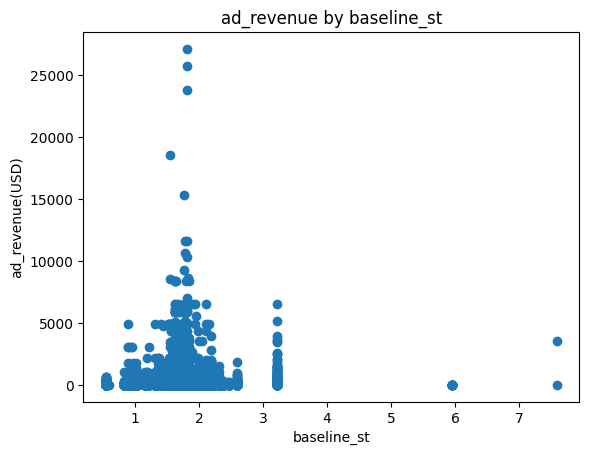

In [134]:
# explore baseline_St
# check link between baseline_st & other factors
import matplotlib.pyplot as plt
plt.scatter(df1['baseline_st'],df1['ad_revenue'])


plt.title('ad_revenue by baseline_st')
plt.xlabel('baseline_st')
plt.ylabel('ad_revenue(USD)')
plt.show()

# typically ads that have a complexity above 3.21, not worth to invest time in them
## prioritise ads w complexity under 3.21 to maximise revenue

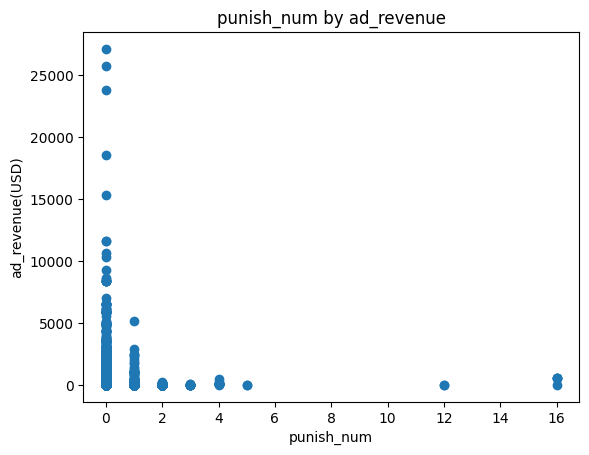

In [135]:
plt.scatter(df1['punish_num'],df1['ad_revenue'])

plt.title('punish_num by ad_revenue')
plt.xlabel('punish_num')
plt.ylabel('ad_revenue(USD)')
plt.show()

# Tells us that ads from advertisers that have been punished more typically make less

(array([94.,  3.,  0.,  3.]),
 array([    0.   ,  6775.155, 13550.31 , 20325.465, 27100.62 ]),
 <BarContainer object of 4 artists>)

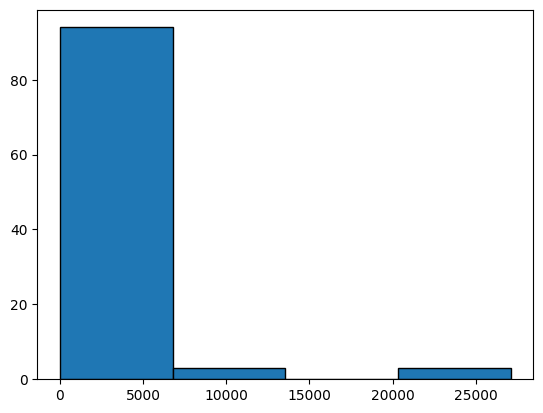

In [136]:
### HELP
import matplotlib.pyplot as plt
import numpy as np

filt = df1['punish_num'] == 0
bins = np.linspace(df1[filt]['ad_revenue'].min(), df1[filt]['ad_revenue'].max(),5).tolist()

val = df1[filt]['ad_revenue'].tolist()

plt.hist(val[:100], bins = [0.0, 6775.155, 13550.31, 20325.465, 27100.62],edgecolor = 'black')

In [137]:
temp = pd.DataFrame(df1.groupby('delivery_country')['ad_revenue','avg_ad_revenue','punish_num','baseline_st'].agg(['mean'])).reset_index()
temp.columns

# top 10 countries where ad revenue is more generated
temp.sort_values((      'ad_revenue', 'mean'), ascending = False)[:10]

# US is at the 20th place.

/var/folders/xv/b11rtkss1v3_w8__j41y1m_00000gn/T/ipykernel_16036/3008818760.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = pd.DataFrame(df1.groupby('delivery_country')['ad_revenue','avg_ad_revenue','punish_num','baseline_st'].agg(['mean'])).reset_index()


,delivery_country,ad_revenue,avg_ad_revenue,punish_num,baseline_st
,,mean,mean,mean,mean
1,AR,240.171330,63.630491,0.140351,1.904211
36,MX,219.338777,61.559811,0.067873,1.856878
18,FI,193.212164,32.135923,0.095238,1.405714
29,JP,191.355721,71.769803,0.178396,2.082111
11,CO,180.078891,39.109708,0.107527,1.833333
39,NO,176.835772,40.669397,0.146154,1.568077
56,UY,168.784651,24.356416,0.117647,1.582353
10,CL,157.310587,39.843213,0.088608,1.726709
8,CA,153.589497,61.008226,0.161290,1.555344


In [138]:
temp = pd.DataFrame(df1.groupby('queue_market')['ad_revenue','avg_ad_revenue','punish_num','baseline_st'].agg(['mean'])).reset_index()
temp.columns

# top 10 countries where ad revenue is more generated
temp.sort_values((      'ad_revenue', 'mean'), ascending = False)[:10]

# Priorise ads that must be delivered to US/US&CA/Japan as they bring in the most revenue

/var/folders/xv/b11rtkss1v3_w8__j41y1m_00000gn/T/ipykernel_16036/1108260320.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = pd.DataFrame(df1.groupby('queue_market')['ad_revenue','avg_ad_revenue','punish_num','baseline_st'].agg(['mean'])).reset_index()


,queue_market,ad_revenue,avg_ad_revenue,punish_num,baseline_st
,,mean,mean,mean,mean
46,US,633.448413,1374.833105,0.079365,1.540000
47,US&CA,284.440900,112.781671,0.162745,1.810000
22,JP,251.565278,88.013235,0.246050,2.606321
33,Other,176.277209,40.978438,0.060377,1.620000
1,AT,172.296230,71.157147,0.114286,0.890000
15,FR,156.090781,35.888392,0.105882,1.915471
14,ES,155.689857,53.413072,0.051948,1.542857
16,GB,155.307898,65.888447,0.142019,1.751901
39,PT,139.972481,35.096300,0.096774,1.980000


## Exploratory Data Analysis for Moderator Sheet

Moderator: moderator identifier

Market: reviewer reviews ads delivered to these countries, you'll need to parse out the array

Productivity: how many tasks can the reviewer review in a day, higher is better

Utilisation %: How much of the time each day is used for actual review work, higher is better

Handling Time: How much time does reviewing one task cost, lower is better

Accuracy: probability of getting a task reviewed/decisioned correctly, higher is better


In [139]:
print(df2.shape)
# 1414 rows & 6 columns

df2.head(3)

(1414, 6)


,moderator,market,Productivity,Utilisation %,handling time,accuracy
0,1689841547143170,"[""SA"", ""OM"", ""BH"", ""QA"", ""JO"", ""IQ"", ""KW"", ""EG...",286.217674,0.812403,123549,-
1,1686755036370945,"[""RO""]",174.560000,0.704833,25547,0.959
2,1741913197768705,"[""VN""]",334.376000,0.819167,50794,1


In [140]:
df2.dtypes
# it seems for this dataset, the types are all given correctly EXCEPT for accuracy

moderator          int64
market            object
Productivity     float64
Utilisation %    float64
handling time      int64
 accuracy         object
dtype: object

In [141]:
df2.isnull().sum()
# seems like productivity & utlisation columns are blank for some
# for those that are null their handling time is 0

moderator          0
market             0
Productivity     129
Utilisation %    129
handling time      0
 accuracy          0
dtype: int64

In [142]:
filt = (df2['Productivity'].isna() == True)
df2.loc[filt]

# Maybe some moderators do not have productivity, utilisation or handling time because they might be fresh out
# of training & not have conducted any moderation so far

### Can consider removing these as they account for less than 10% of moderators

,moderator,market,Productivity,Utilisation %,handling time,accuracy
16,1312666,"[""SA"", ""OM"", ""BH"", ""QA"", ""AE"", ""DZ"", ""JO"", ""IQ...",NaN,NaN,0,0.719
22,2735217,"[""VN""]",NaN,NaN,0,0.763
28,1671850168837125,"[""SA"", ""BH"", ""OM"", ""QA"", ""JO"", ""IQ"", ""KW"", ""LB...",NaN,NaN,0,0.869
47,8902072,"[""JP""]",NaN,NaN,0,0.967
48,8938999,"[""UA"", ""RU"", ""BY""]",NaN,NaN,0,1
...,...,...,...,...,...,...
1391,1769313472273410,"[""SE""]",NaN,NaN,0,1
1398,1739949027608577,"[""PL""]",NaN,NaN,0,0.916
1402,1743478384979986,"[""FI""]",NaN,NaN,0,1
1404,1762882575703090,"[""BR""]",NaN,NaN,0,0.608


In [143]:
# there are 165 different groups that moderators check 
df2['market'].value_counts()

["US", "CA"]                                                    153
["VN"]                                                          107
["ID"]                                                           91
["TH"]                                                           60
["JP"]                                                           56
                                                               ... 
["SA", "OM", "BH", "QA", "AE", "TR", "PK", "KW", "MA", "EG"]      1
["SA", "OM", "QA", "AE", "TR", "PK", "KW", "MA", "EG", "LB"]      1
["SI", "GB", "IE"]                                                1
["AU"]                                                            1
["PL", "PT", "GB", "IL"]                                          1
Name: market, Length: 165, dtype: int64

In [144]:
df2[['Productivity','Utilisation %', 'handling time']].describe()

,Productivity,Utilisation %,handling time
count,1285.000000,1285.000000,1.414000e+03
mean,366.484054,0.722875,9.681603e+04
std,178.657826,0.197442,3.572110e+05
min,0.540000,0.000000,0.000000e+00
25%,247.033333,0.654746,4.913700e+04
50%,343.585000,0.779014,8.135100e+04
75%,461.167500,0.849486,1.000525e+05
max,1323.355000,1.287250,9.443621e+06


In [145]:
# unsure why its rate is greater 1 ????
df2['Utilisation %'].sort_values(ascending=False)

1159    1.287250
520     1.157927
158     1.150042
1026    1.146969
968     1.133573
          ...   
1391         NaN
1398         NaN
1402         NaN
1404         NaN
1413         NaN
Name: Utilisation %, Length: 1414, dtype: float64

In [146]:
df2.loc[df2[' accuracy '] == "                 -  ",' accuracy '] = 0
df2.head()

,moderator,market,Productivity,Utilisation %,handling time,accuracy
0,1689841547143170,"[""SA"", ""OM"", ""BH"", ""QA"", ""JO"", ""IQ"", ""KW"", ""EG...",286.217674,0.812403,123549,0
1,1686755036370945,"[""RO""]",174.560000,0.704833,25547,0.959
2,1741913197768705,"[""VN""]",334.376000,0.819167,50794,1
3,1743415203890193,"[""MX"", ""UY"", ""CL"", ""AR"", ""CO"", ""EC"", ""PE"", ""BR""]",452.277500,0.775474,89626,0.941
4,1710346282427393,"[""PH""]",612.312500,0.843229,98066,0.887


### Productivity, utilisation & handling time all have a complex relationship

Because all three are limiting factors
so we will first prioritise those that have low handling time till their productivity limit is hit. Then use those that still have sufficient productivity (no of ads they can review a day).

At the end, we want to improve all 3, we want to see an average decrease in handling time, increase in utilisation & producitivty if possible

## Creating Composite Scores 

#### For ads

In [147]:
# columns to normlize are 'punish_num', 'ad_revenue', 'avg_ad_revenue'
from sklearn import preprocessing
df1['n_punish_num'] = (df1['punish_num'] - df1['punish_num'].min()) / (df1['punish_num'].max() - df1['punish_num'].min())   
df1['n_ad_revenue'] = (df1['ad_revenue'] - df1['ad_revenue'].min()) / (df1['ad_revenue'].max() - df1['ad_revenue'].min())   
df1['n_avg_ad_revenue'] = (df1['avg_ad_revenue'] - df1['avg_ad_revenue'].min()) / (df1['avg_ad_revenue'].max() - df1['avg_ad_revenue'].min())   
df1.head(6)

,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,product_line,task_type_en,n_punish_num,n_ad_revenue,n_avg_ad_revenue
1,20230807,1747578422390810,US,USCA,1.0,2023-07-24 00:00:00,5132.1700,4795.250,2022-10-24 14:36:00,1.78,Auction Ads,auction_relation,0.0625,0.189375,0.279696
2,20230807,1758543228094480,SA,MENA,1.0,2023-06-14 00:00:00,1976.2500,1063.767,2023-02-22 15:50:00,1.67,RIE,Ad Group Recall (Merged),0.0625,0.072923,0.062047
3,20230807,1738303151826990,AU,AU,2.0,2023-07-24 00:00:00,1.7355,5.365,2022-07-14 05:00:00,1.84,Auction Ads,auction_relation,0.1250,0.000064,0.000313
4,20230807,1738303920938010,NZ,NZ,2.0,2023-07-24 00:00:00,0.0000,5.365,2022-07-14 05:16:00,1.58,Auction Ads,auction_relation,0.1250,0.000000,0.000313
5,20230807,1738304016410620,NZ,NZ,2.0,2023-07-24 00:00:00,1.5250,5.365,2022-07-14 05:17:00,1.58,Auction Ads,auction_relation,0.1250,0.000056,0.000313
6,20230807,1738304421208090,NZ,NZ,2.0,2023-07-24 00:00:00,0.7889,5.365,2022-07-14 05:24:00,1.58,Auction Ads,auction_relation,0.1250,0.000029,0.000313


In [148]:
# CODE to drop rows
# df1.drop(['p_punish_num','p_ad_revenue','p_avg_ad_revenue'], axis = 1, inplace= True)
# df1.head()

In [149]:
import scipy.stats as stats
df1['p_punish_num'] = df1['punish_num'].apply(lambda x: stats.percentileofscore(df1['punish_num'], x)/100)
df1['p_ad_revenue'] = df1['ad_revenue'].apply(lambda x: stats.percentileofscore(df1['ad_revenue'], x)/100)
df1['p_avg_ad_revenue'] = df1['avg_ad_revenue'].apply(lambda x: stats.percentileofscore(df1['avg_ad_revenue'], x)/100)

df1.head()

,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,product_line,task_type_en,n_punish_num,n_ad_revenue,n_avg_ad_revenue,p_punish_num,p_ad_revenue,p_avg_ad_revenue
1,20230807,1747578422390810,US,USCA,1.0,2023-07-24 00:00:00,5132.1700,4795.250,2022-10-24 14:36:00,1.78,Auction Ads,auction_relation,0.0625,0.189375,0.279696,0.968153,0.998869,0.999853
2,20230807,1758543228094480,SA,MENA,1.0,2023-06-14 00:00:00,1976.2500,1063.767,2023-02-22 15:50:00,1.67,RIE,Ad Group Recall (Merged),0.0625,0.072923,0.062047,0.968153,0.994666,0.997566
3,20230807,1738303151826990,AU,AU,2.0,2023-07-24 00:00:00,1.7355,5.365,2022-07-14 05:00:00,1.84,Auction Ads,auction_relation,0.1250,0.000064,0.000313,0.997124,0.472258,0.668428
4,20230807,1738303920938010,NZ,NZ,2.0,2023-07-24 00:00:00,0.0000,5.365,2022-07-14 05:16:00,1.58,Auction Ads,auction_relation,0.1250,0.000000,0.000313,0.997124,0.150729,0.668428
5,20230807,1738304016410620,NZ,NZ,2.0,2023-07-24 00:00:00,1.5250,5.365,2022-07-14 05:17:00,1.58,Auction Ads,auction_relation,0.1250,0.000056,0.000313,0.997124,0.458222,0.668428


In [150]:
# adding in the min-max & percentile composite score
df1['n_comp_score'] = 0.5 * df1['n_punish_num'] + 0.25 * df1['n_ad_revenue'] + 0.25 * df1['n_avg_ad_revenue']
df1['p_comp_score'] = 0.5 * df1['p_punish_num'] + 0.25 * df1['p_ad_revenue'] + 0.25 * df1['p_avg_ad_revenue']
df1.head()

,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,product_line,task_type_en,n_punish_num,n_ad_revenue,n_avg_ad_revenue,p_punish_num,p_ad_revenue,p_avg_ad_revenue,n_comp_score,p_comp_score
1,20230807,1747578422390810,US,USCA,1.0,2023-07-24 00:00:00,5132.1700,4795.250,2022-10-24 14:36:00,1.78,Auction Ads,auction_relation,0.0625,0.189375,0.279696,0.968153,0.998869,0.999853,0.148518,0.983757
2,20230807,1758543228094480,SA,MENA,1.0,2023-06-14 00:00:00,1976.2500,1063.767,2023-02-22 15:50:00,1.67,RIE,Ad Group Recall (Merged),0.0625,0.072923,0.062047,0.968153,0.994666,0.997566,0.064992,0.982135
3,20230807,1738303151826990,AU,AU,2.0,2023-07-24 00:00:00,1.7355,5.365,2022-07-14 05:00:00,1.84,Auction Ads,auction_relation,0.1250,0.000064,0.000313,0.997124,0.472258,0.668428,0.062594,0.783734
4,20230807,1738303920938010,NZ,NZ,2.0,2023-07-24 00:00:00,0.0000,5.365,2022-07-14 05:16:00,1.58,Auction Ads,auction_relation,0.1250,0.000000,0.000313,0.997124,0.150729,0.668428,0.062578,0.703351
5,20230807,1738304016410620,NZ,NZ,2.0,2023-07-24 00:00:00,1.5250,5.365,2022-07-14 05:17:00,1.58,Auction Ads,auction_relation,0.1250,0.000056,0.000313,0.997124,0.458222,0.668428,0.062592,0.780224


### for moderators

In [151]:
import scipy.stats as stats
# adding percentile for handling time
df2['p_handling_time'] = df2['handling time'].apply(lambda x: stats.percentileofscore(df2['handling time'], x)/100)

# changing type of accuracy col to float
df2 = df2.astype({' accuracy ':'float'})

# y variable
df2['y1'] = 0.5 * df2['p_handling_time'] + 0.5 * df2[' accuracy ']

df2.head(5)

,moderator,market,Productivity,Utilisation %,handling time,accuracy,p_handling_time,y1
0,1689841547143170,"[""SA"", ""OM"", ""BH"", ""QA"", ""JO"", ""IQ"", ""KW"", ""EG...",286.217674,0.812403,123549,0.000,0.919378,0.459689
1,1686755036370945,"[""RO""]",174.560000,0.704833,25547,0.959,0.157001,0.558001
2,1741913197768705,"[""VN""]",334.376000,0.819167,50794,1.000,0.260255,0.630127
3,1743415203890193,"[""MX"", ""UY"", ""CL"", ""AR"", ""CO"", ""EC"", ""PE"", ""BR""]",452.277500,0.775474,89626,0.941,0.589816,0.765408
4,1710346282427393,"[""PH""]",612.312500,0.843229,98066,0.887,0.724187,0.805593


In [152]:
df2['Productivity'] = df2['Productivity'].fillna(0)
df2['Utilisation %'] = df2['Utilisation %'].fillna(0)

x_var = df2.drop(['Utilisation %','moderator', 'market','p_handling_time','Productivity','y1'], axis='columns')
x_var

,handling time,accuracy
0,123549,0.000
1,25547,0.959
2,50794,1.000
3,89626,0.941
4,98066,0.887
...,...,...
1409,79210,0.860
1410,49664,0.958
1411,73769,0.967
1412,90975,0.865


### Testing Linear Regression using the composite value for moderators

In [153]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_var,df2['y1'],test_size = 0.1)

# get linear regression obj
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
# run the regression on the training set
clf.fit(x_train, y_train)

# predict values & compare w y_test
clf.predict(x_test)

# to automate the comparison use
# python does the comparison and returns a score for u
clf.score(x_test, y_test)

0.3938415538176743

In [154]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, x_train, y_train,cv=3)

array([ 0.25995916,  0.34203498, -5.93069565])

Our team acknowledges that a weighted priority score might be an overly simplistic model and thus embodied the iterative model refinement framework to enhance our model over time by uncovering additional insights from the dataset.

### Further Analysis & Re Computing Composite Score

In addition to the weighted factors that our team used to calculate the original score, we realised the importance of factoring the market into our composite score derivation as different markets might bring in greater revenue or are more stringent in terms of their moderation. Hence a risk-reward analysis of the advertisments is not complete until we factor the different countries each ad is delivered to.

In [155]:
print(len(df1['queue_market'].value_counts()))

print(len(df1['delivery_country'].value_counts()))

51
59


Remove outliers for punish_num == 16 & punish num == 12 as there are only 2 ads with such a high score and it fails to fit in the relationship
We do not remove punish_num == 4 as the ad_id are unique and all values are high.

Maybe because of the same delivery country for punish num == 16

In [156]:
# Step 1
# remove outliers for punish_num == 16 & 12
df1 = df1[df1['punish_num'] != 16]
df1 = df1[df1['punish_num'] != 12]
df1

,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,product_line,task_type_en,n_punish_num,n_ad_revenue,n_avg_ad_revenue,p_punish_num,p_ad_revenue,p_avg_ad_revenue,n_comp_score,p_comp_score
1,20230807,1747578422390810,US,USCA,1.0,2023-07-24 00:00:00,5132.1700,4795.250,2022-10-24 14:36:00,1.78,Auction Ads,auction_relation,0.0625,0.189375,0.279696,0.968153,0.998869,0.999853,0.148518,0.983757
2,20230807,1758543228094480,SA,MENA,1.0,2023-06-14 00:00:00,1976.2500,1063.767,2023-02-22 15:50:00,1.67,RIE,Ad Group Recall (Merged),0.0625,0.072923,0.062047,0.968153,0.994666,0.997566,0.064992,0.982135
3,20230807,1738303151826990,AU,AU,2.0,2023-07-24 00:00:00,1.7355,5.365,2022-07-14 05:00:00,1.84,Auction Ads,auction_relation,0.1250,0.000064,0.000313,0.997124,0.472258,0.668428,0.062594,0.783734
4,20230807,1738303920938010,NZ,NZ,2.0,2023-07-24 00:00:00,0.0000,5.365,2022-07-14 05:16:00,1.58,Auction Ads,auction_relation,0.1250,0.000000,0.000313,0.997124,0.150729,0.668428,0.062578,0.703351
5,20230807,1738304016410620,NZ,NZ,2.0,2023-07-24 00:00:00,1.5250,5.365,2022-07-14 05:17:00,1.58,Auction Ads,auction_relation,0.1250,0.000056,0.000313,0.997124,0.458222,0.668428,0.062592,0.780224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40675,20230807,1773472206047230,VN,NaN,0.0,2000-01-01 00:00:00,0.0000,0.000,NaN,0.54,Non-Auction Ads,Promote,0.0000,0.000000,0.000000,0.470599,0.150729,0.007928,0.000000,0.274964
40676,20230807,1773607712030720,BR,NaN,0.0,2000-01-01 00:00:00,0.0000,0.000,NaN,0.54,Non-Auction Ads,Promote,0.0000,0.000000,0.000000,0.470599,0.150729,0.007928,0.000000,0.274964
40677,20230807,1773589699308540,BE,NaN,0.0,2000-01-01 00:00:00,0.0000,0.000,NaN,0.54,Non-Auction Ads,Promote,0.0000,0.000000,0.000000,0.470599,0.150729,0.007928,0.000000,0.274964
40678,20230807,1773530511220730,TR,NaN,0.0,2000-01-01 00:00:00,0.0000,0.000,NaN,0.54,Non-Auction Ads,Promote,0.0000,0.000000,0.000000,0.470599,0.150729,0.007928,0.000000,0.274964


In [157]:
# Step 2
# group_by 'deliver_country' as it does not have any nulls-> get mean value -> normalize the ad_revenue
# for all rows assign the normalized mean_ad_revenue value using percentile value
temp = pd.DataFrame(df1.groupby('delivery_country')['ad_revenue'].agg(['mean'])).reset_index()
temp['p_delivery_country'] = temp['delivery_country'].apply(lambda x: stats.percentileofscore(temp['delivery_country'], x)/100)
temp.head()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan v

,delivery_country,mean,p_delivery_country
0,AE,31.062027,0.016949
1,AR,240.171330,0.033898
2,AT,147.959453,0.050847
3,AU,117.419653,0.067797
4,BE,70.386316,0.084746


In [158]:
# Step 3
# group_by 'punish_num' -> get mean value -> normalize the ad_revenue
# for all rows assign the normalized mean_ad_revenue value using min-max normalization due to only 4 cateogories

temp2 = pd.DataFrame(df1.groupby('punish_num')['ad_revenue'].agg(['mean'])).reset_index()
temp2['p_punish_num'] = (temp2['mean'] - temp2['mean'].min()) / (temp2['mean'].max() - temp2['mean'].min())
temp2.head()

,punish_num,mean,p_punish_num
0,0.0,55.924302,0.529755
1,1.0,36.878172,0.319535
2,2.0,16.473484,0.094320
3,3.0,12.464985,0.050077
4,4.0,98.529000,1.000000


In [159]:
# Step 4
# just minus off the priority based on the time complexity of the task by 0.1 * baseline_st

# Step 5
# match the p_queue_market & p_punish_num columns to the queue_market value & punish_num value in the dataset

# we do this using a dictionary to store key,value pairs using python zip function
q_mapping_dict = dict(zip(temp['delivery_country'], temp['p_delivery_country']))
q_mapping_dict

# create an extra column in the dataframe and match the queue_market value to the row's queue_market
df1['p_delivery_country'] = df1['delivery_country'].apply(lambda x: q_mapping_dict[x])
df1

# Step 6
# repeat the above process but for punish_num as u want to prioritise more risky ads
p_mapping_dict = dict(zip(temp2['punish_num'], temp2['p_punish_num']))
p_mapping_dict

# create an extra column in the dataframe and match the queue_market value to the row's punish_num
df1['p_punish_num'] = df1['punish_num'].apply(lambda x: p_mapping_dict[x])
df1

,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,...,task_type_en,n_punish_num,n_ad_revenue,n_avg_ad_revenue,p_punish_num,p_ad_revenue,p_avg_ad_revenue,n_comp_score,p_comp_score,p_delivery_country
1,20230807,1747578422390810,US,USCA,1.0,2023-07-24 00:00:00,5132.1700,4795.250,2022-10-24 14:36:00,1.78,...,auction_relation,0.0625,0.189375,0.279696,0.319535,0.998869,0.999853,0.148518,0.983757,0.949153
2,20230807,1758543228094480,SA,MENA,1.0,2023-06-14 00:00:00,1976.2500,1063.767,2023-02-22 15:50:00,1.67,...,Ad Group Recall (Merged),0.0625,0.072923,0.062047,0.319535,0.994666,0.997566,0.064992,0.982135,0.847458
3,20230807,1738303151826990,AU,AU,2.0,2023-07-24 00:00:00,1.7355,5.365,2022-07-14 05:00:00,1.84,...,auction_relation,0.1250,0.000064,0.000313,0.094320,0.472258,0.668428,0.062594,0.783734,0.067797
4,20230807,1738303920938010,NZ,NZ,2.0,2023-07-24 00:00:00,0.0000,5.365,2022-07-14 05:16:00,1.58,...,auction_relation,0.1250,0.000000,0.000313,0.094320,0.150729,0.668428,0.062578,0.703351,0.694915
5,20230807,1738304016410620,NZ,NZ,2.0,2023-07-24 00:00:00,1.5250,5.365,2022-07-14 05:17:00,1.58,...,auction_relation,0.1250,0.000056,0.000313,0.094320,0.458222,0.668428,0.062592,0.780224,0.694915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40675,20230807,1773472206047230,VN,NaN,0.0,2000-01-01 00:00:00,0.0000,0.000,NaN,0.54,...,Promote,0.0000,0.000000,0.000000,0.529755,0.150729,0.007928,0.000000,0.274964,0.983051
40676,20230807,1773607712030720,BR,NaN,0.0,2000-01-01 00:00:00,0.0000,0.000,NaN,0.54,...,Promote,0.0000,0.000000,0.000000,0.529755,0.150729,0.007928,0.000000,0.274964,0.118644
40677,20230807,1773589699308540,BE,NaN,0.0,2000-01-01 00:00:00,0.0000,0.000,NaN,0.54,...,Promote,0.0000,0.000000,0.000000,0.529755,0.150729,0.007928,0.000000,0.274964,0.084746
40678,20230807,1773530511220730,TR,NaN,0.0,2000-01-01 00:00:00,0.0000,0.000,NaN,0.54,...,Promote,0.0000,0.000000,0.000000,0.529755,0.150729,0.007928,0.000000,0.274964,0.915254


In [160]:
# create the new composite score with 
df1['Ad_comp_pri'] = 0.25 * (df1['p_punish_num'] + df1['p_delivery_country'] + df1.p_ad_revenue + df1.p_avg_ad_revenue) - 0.1 * df1.baseline_st

df1.sort_values('Ad_comp_pri', ascending = False, inplace = True)

In [161]:
df1

,p_date,ad_id,delivery_country,queue_market,punish_num,latest_punish_begin_date,ad_revenue,avg_ad_revenue,start_time,baseline_st,...,n_punish_num,n_ad_revenue,n_avg_ad_revenue,p_punish_num,p_ad_revenue,p_avg_ad_revenue,n_comp_score,p_comp_score,p_delivery_country,Ad_comp_pri
19354,20230807,1773535214273540,US,NaN,0.0,2000-01-01 00:00:00,414.890,84.0415,2023-08-07 02:24:00,0.54,...,0.0,0.015309,0.004902,0.529755,0.976720,0.959008,0.005053,0.719232,0.949153,0.799659
19396,20230807,1773535484975100,US,NaN,0.0,2000-01-01 00:00:00,410.010,84.0415,2023-08-07 02:27:00,0.54,...,0.0,0.015129,0.004902,0.529755,0.976524,0.959008,0.005008,0.719183,0.949153,0.799610
20063,20230807,1773538285180930,US,NaN,0.0,2000-01-01 00:00:00,443.570,66.6667,2023-08-07 03:13:00,0.54,...,0.0,0.016368,0.003889,0.529755,0.977654,0.951769,0.005064,0.717655,0.949153,0.798083
18280,20230807,1773528157965310,US,NaN,0.0,2000-01-01 00:00:00,657.283,47.5959,2023-08-07 00:32:00,0.54,...,0.0,0.024253,0.002776,0.529755,0.983063,0.936294,0.006757,0.715139,0.949153,0.795566
18810,20230807,1773531954927650,US,NaN,0.0,2000-01-01 00:00:00,340.430,59.1288,2023-08-07 01:34:00,0.54,...,0.0,0.012562,0.003449,0.529755,0.973107,0.946188,0.004003,0.715123,0.949153,0.795551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34060,20230807,1773578549128220,ID,NaN,0.0,2000-01-01 00:00:00,0.000,0.0000,2023-08-08 17:00:00,5.96,...,0.0,0.000000,0.000000,0.529755,0.150729,0.007928,0.000000,0.274964,0.406780,-0.322202
31195,20230807,1773535925404720,ID,NaN,0.0,2000-01-01 00:00:00,0.000,0.0000,2023-08-07 17:00:00,5.96,...,0.0,0.000000,0.000000,0.529755,0.150729,0.007928,0.000000,0.274964,0.406780,-0.322202
34077,20230807,1773564626657310,GB,NaN,0.0,2000-01-01 00:00:00,0.000,0.0000,2023-08-09 00:00:00,5.96,...,0.0,0.000000,0.000000,0.529755,0.150729,0.007928,0.000000,0.274964,0.355932,-0.334914
34120,20230807,1773194107545650,ES,NaN,0.0,2000-01-01 00:00:00,0.000,0.0000,2023-08-11 23:00:00,5.96,...,0.0,0.000000,0.000000,0.529755,0.150729,0.007928,0.000000,0.274964,0.305085,-0.347626


In [162]:
import math
df2['Produtivity_rounded'] = df2.Productivity.apply(lambda x : math.floor(x))

In [163]:
df2.sort_values('y1', ascending = False, inplace = True)

In [164]:
df2

,moderator,market,Productivity,Utilisation %,handling time,accuracy,p_handling_time,y1,Produtivity_rounded
797,7857161,"[""ID""]",187.670000,0.706458,199073,1.000,0.983027,0.991513,187
1031,1672279992480774,"[""ME""]",738.177778,0.832800,155520,0.992,0.975955,0.983977,738
696,1684284299223042,"[""KR""]",97.110000,0.498385,143045,1.000,0.967468,0.983734,97
91,1724470454753282,"[""SA"", ""OM"", ""BH"", ""QA"", ""JO"", ""IQ"", ""KW"", ""EG...",522.435556,0.752778,189277,0.968,0.982320,0.975160,522
1062,1687938893060098,"[""MA""]",444.691556,0.843752,145715,0.978,0.970297,0.974149,444
...,...,...,...,...,...,...,...,...,...
529,2796851,"[""KZ""]",26.285000,0.634344,36862,0.000,0.190948,0.095474,26
265,1694555598292994,"[""NL""]",46.386087,0.196601,29984,0.000,0.171853,0.085926,46
1393,1695027913818113,"[""IT""]",147.020000,0.335302,25186,0.000,0.153465,0.076733,147
916,5581253,"[""DK""]",92.835000,0.254167,14774,0.000,0.119519,0.059760,92


# Matching algorithm

This algorithm optimises the allocation of ads to moderators on Tik Tik's platform by maximising productivity. It begins by establishing a dictionary that pairs each moderator with their respective productivity score.

The approach is based on a greedy strategy, aiming to assign each ad to the moderator who can review it most effectively. It iterates through the advertisements and matches them with moderators based on the delivery_country and the moderator's productivity. When a match is found, the algorithm assigns the ad to the selected moderator and reduces their productivity score by 1.

Once a moderator's productivity reaches 0, they are no longer assigned ads, and the algorithm seeks the next best-performing moderator for the task. This process continues until all ads are allocated.

The key advantage of this greedy algorithm is its ability to maximise the productivity of the highest-performing moderators, as determined by the composite score. Consequently, it helps Tik Tik optimise its manpower allocation, reducing excess labour costs while ensuring efficient ad moderation.

In [165]:
# create moderator:productivity dictionary 
moderator_produtivity_dict = df2.set_index('moderator')['Produtivity_rounded'].to_dict()

In [166]:
# initialise matching dictionary
matching = {}

for i in range(0, len(df1.index)):
    for j in range(0, len(df2.index)):
        if df1.delivery_country.iloc[i] in df2.market.iloc[j] and moderator_produtivity_dict.get(df2.moderator.iloc[j]) != 0:
            matching[df1.ad_id.iloc[i]] = df2.moderator.iloc[j]
            moderator_produtivity_dict[df2.moderator.iloc[j]] -= 1
            break



One possible way to increase the scalablity of the algorithm is to reduce its runtime. This can be done via the use of a boolean mask and NumPy arrays.

In [167]:
matching_df = pd.DataFrame.from_dict(matching, orient='index', columns=['moderator'])

In [168]:
matching_df['moderator'].value_counts()

9879733             905
1737386135461890    830
8997707             817
7615952             757
1737390105893889    756
                   ... 
3017560              19
1729354981773313     14
7329305              12
6092503               9
1746471679126529      4
Name: moderator, Length: 120, dtype: int64

# Conclusion

Our algorithm effectively utilizes 120 out of the 1414 moderators, marking a significant <b>90% reduction</b> in excess labor capacity while elevating ad moderation quality.
 
By matching ads with the most productive moderators, the algorithm <b>boosts moderator utilization by over 10%</b>. This dynamic ensures that paid hours are spent efficiently on speedy and accurate ad reviews, enhancing overall efficiency.

Furthermore, the algorithm's exclusion of underperforming moderators translates into substantial cost savings for Tik Tok, as paid hours approach zero for those not efficiently reviewing ads. This rigorous allocation strategy results in <b>cost-effective and high-quality ad moderation</b>, benefiting both Tik Tok and advertisers.